nutrition prediction

# 📦 Step 1: Imports

In [1]:
import os
import json
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor


# 🔁 Step 2: Load All JSON Files

In [2]:
import os
import json

def load_all_products(path='products'):
    data = []
    for file in os.listdir(path):
        if file.endswith('.json'):
            file_path = os.path.join(path, file)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = json.load(f)
                    if isinstance(content, list):
                        data.extend(content)
                    elif isinstance(content, dict):
                        data.append(content)
            except Exception as e:
                print(f"⚠️ Error loading {file}: {e}")
    return data


# 📥 Load and display summary
raw_data = load_all_products("products")  # Update folder name if needed
print(f"\n📦 Total raw product entries loaded: {len(raw_data)}")

# 🧐 Preview one product if available
if raw_data:
    print("\n📄 Sample raw_data[0]:")
    print(json.dumps(raw_data[0], indent=2, ensure_ascii=False))
else:
    print("❌ No data loaded.")


📦 Total raw product entries loaded: 2570

📄 Sample raw_data[0]:
{
  "ean": "salade-pecheur-35g",
  "business_type": "food",
  "categories": [
    {
      "label": "Algues, Graines à germer"
    }
  ],
  "market": {
    "name": "Naturalia",
    "country": "FR",
    "address": "Paris"
  },
  "lang_desc": {
    "fr": {
      "title": "SALADE DU PÊCHEUR AUX 3 ALGUES 35G BIO",
      "desc": "Salade du pêcheur aux 3 algues 35G Bio.\nDécouvrez la salade du pêcheur aux trois algues déshydratées: Dulse, Nori, et Laitue de mer.\n100% Bio.",
      "images": [
        "https://media.naturalia.fr/media/catalog/product/cache/c97961dbe2ef8ae9072b778469b58f9a/3/5/3565840206090_1.jpg"
      ],
      "links": {
        "links_self": "https://www.naturalia.fr/produit/salade-pecheur-35g"
      }
    }
  },
  "evolutions": [
    {
      "parsing_date": "2025-06-15T22:25",
      "format": "35G",
      "availability": true,
      "nutrition": {
        "minerals": {
          "salt": 4400
        },
       

# 📦 Step 3: Flatten and Extract Relevant Fields

In [3]:
def extract_product_info(product):
    try:
        evolution = product.get("evolutions", [{}])[0]
        nutrition = evolution.get("nutrition", {})
        energies = nutrition.get("energies", {})
        minerals = nutrition.get("minerals", {})
        fats = nutrition.get("fats", {})
        proteins = nutrition.get("proteins", {})
        carbs = nutrition.get("carbohydrates", {})

        return {
            "ean": product.get("ean"),
            "title": product.get("lang_desc", {}).get("fr", {}).get("title"),
            "desc": product.get("lang_desc", {}).get("fr", {}).get("desc"),
            "brand": product.get("brand", {}).get("name"),
            "category": product.get("categories", [{}])[0].get("label"),
            "origin": product.get("origin", {}).get("explicit"),
            "market": product.get("market", {}).get("name"),
            "country": product.get("market", {}).get("country"),
            "ingredients": evolution.get("ingredients"),
            "fats": fats.get("fats"),
            "saturates": fats.get("saturates"),
            "salt": minerals.get("salt"),
            "proteins": proteins.get("proteins"),
            "carbohydrates": carbs.get("carbohydrates"),
            "kj": energies.get("kj"),
            "nutriscore": evolution.get("nutriscore"),
            "price": evolution.get("price_per_packaging"),
            "discounted": evolution.get("on_discount"),
            "requires_loyalty_card": evolution.get("requires_loyalty_card"),
            "reviews_avg": product.get("customer_reviews", {}).get("average_rating"),
            "reviews_total": product.get("customer_reviews", {}).get("total_reviews")
        }
    except Exception as e:
        print(f"❌ Error in product {product.get('ean')}: {e}")
        return None


products_data = [extract_product_info(prod) for prod in raw_data]
df = pd.DataFrame([p for p in products_data if p is not None])

print(f"✅ Extracted {len(df)} valid product entries.\n")
print(df.head())

✅ Extracted 2570 valid product entries.

                        ean  \
0        salade-pecheur-35g   
1    germoir-verre-germline   
2  alfa-cress-ch-rouge-150g   
3   alfa-radis-fenouil-150g   
4     alfalfa-a-germer-150g   

                                               title  \
0             SALADE DU PÊCHEUR AUX 3 ALGUES 35G BIO   
1             GERMOIR EN VERRE POUR GRAINES À GERMER   
2  ALFA CRESSON CHOU ROUGE GRAINES À GERMER 150G BIO   
3       ALFA RADIS FENOUIL GRAINES À GERMER 150G BIO   
4                  ALFALFA GRAINES À GERMER 150G BIO   

                                                desc brand  \
0  Salade du pêcheur aux 3 algues 35G Bio.\nDécou...  None   
1  Germoir en verre pour graines à germer.\nVous ...  None   
2  Alfa Cresson Chou Rouge graines à germer 150G ...  None   
3  Alfa Radis Fenouil graines à germer 150G Bio\n...  None   
4  Alfalfa graines à germer 150G Bio\nDe la famil...  None   

                   category origin     market country  \
0  Al

# 🧹 Step 4: NLP Cleaning

In [4]:
nlp = spacy.load("fr_core_news_sm")
nltk.download('stopwords')
french_stopwords = set(stopwords.words('french'))

def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation and digits (keep letters and spaces)
    text = re.sub(r'[^a-zàâçéèêëîïôûùüÿñæœ\s]', '', text)
    # Tokenize using spacy for better lemmatization
    doc = nlp(text)
    # Lemmatize and remove stopwords
    tokens = [token.lemma_ for token in doc if token.lemma_ not in french_stopwords and len(token.lemma_) > 2]
    return " ".join(tokens)

# Apply cleaning to relevant columns:
df['clean_desc'] = df['desc'].apply(clean_text)
df['clean_ingredients'] = df['ingredients'].apply(clean_text)

# Check sample output
print(df[['desc', 'clean_desc']].head(3))
print(df[['ingredients', 'clean_ingredients']].head(3))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amine\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                desc  \
0  Salade du pêcheur aux 3 algues 35G Bio.\nDécou...   
1  Germoir en verre pour graines à germer.\nVous ...   
2  Alfa Cresson Chou Rouge graines à germer 150G ...   

                                          clean_desc  
0  salad pêcheur algue bio découvrir salade pêche...  
1  germoir verre graine germer aller pouvoir déco...  
2  alfa cresson chou rouge graine germer gramme b...  
                                         ingredients  \
0  Dulse*, laitue de mer*, nori*.\n*Issu de l'Agr...   
1                                               None   
2  75% graines d'alfalfa à germer (Medicago sativ...   

                                   clean_ingredients  
0  dulse laitue mer nori issu lagriculture biolog...  
1                                                     
2  graine dalfalfer germer medicago sativa issu l...  


In [5]:
print(df.iloc[0])

ean                                                     salade-pecheur-35g
title                               SALADE DU PÊCHEUR AUX 3 ALGUES 35G BIO
desc                     Salade du pêcheur aux 3 algues 35G Bio.\nDécou...
brand                                                                 None
category                                          Algues, Graines à germer
origin                                                                None
market                                                           Naturalia
country                                                                 FR
ingredients              Dulse*, laitue de mer*, nori*.\n*Issu de l'Agr...
fats                                                                   1.4
saturates                                                              NaN
salt                                                                4400.0
proteins                                                              18.0
carbohydrates            

Full Pipeline with Multiple Models and Correlation Visualization


📌 Ridge Performance:
→ fats: MSE=16.91, R²=0.67
→ saturates: MSE=4.14, R²=0.76
→ salt: MSE=0.07, R²=0.59
→ proteins: MSE=5.88, R²=0.77
→ carbohydrates: MSE=52.88, R²=0.78

📌 LinearRegression Performance:
→ fats: MSE=98.45, R²=-0.94
→ saturates: MSE=35.50, R²=-1.03
→ salt: MSE=0.46, R²=-1.88
→ proteins: MSE=22.26, R²=0.13
→ carbohydrates: MSE=226.10, R²=0.06

📌 RandomForest Performance:
→ fats: MSE=11.70, R²=0.77
→ saturates: MSE=3.20, R²=0.82
→ salt: MSE=0.06, R²=0.64
→ proteins: MSE=3.07, R²=0.88
→ carbohydrates: MSE=41.50, R²=0.83

📌 XGBoost Performance:
→ fats: MSE=10.79, R²=0.79
→ saturates: MSE=2.72, R²=0.84
→ salt: MSE=0.06, R²=0.63
→ proteins: MSE=3.48, R²=0.86
→ carbohydrates: MSE=35.67, R²=0.85


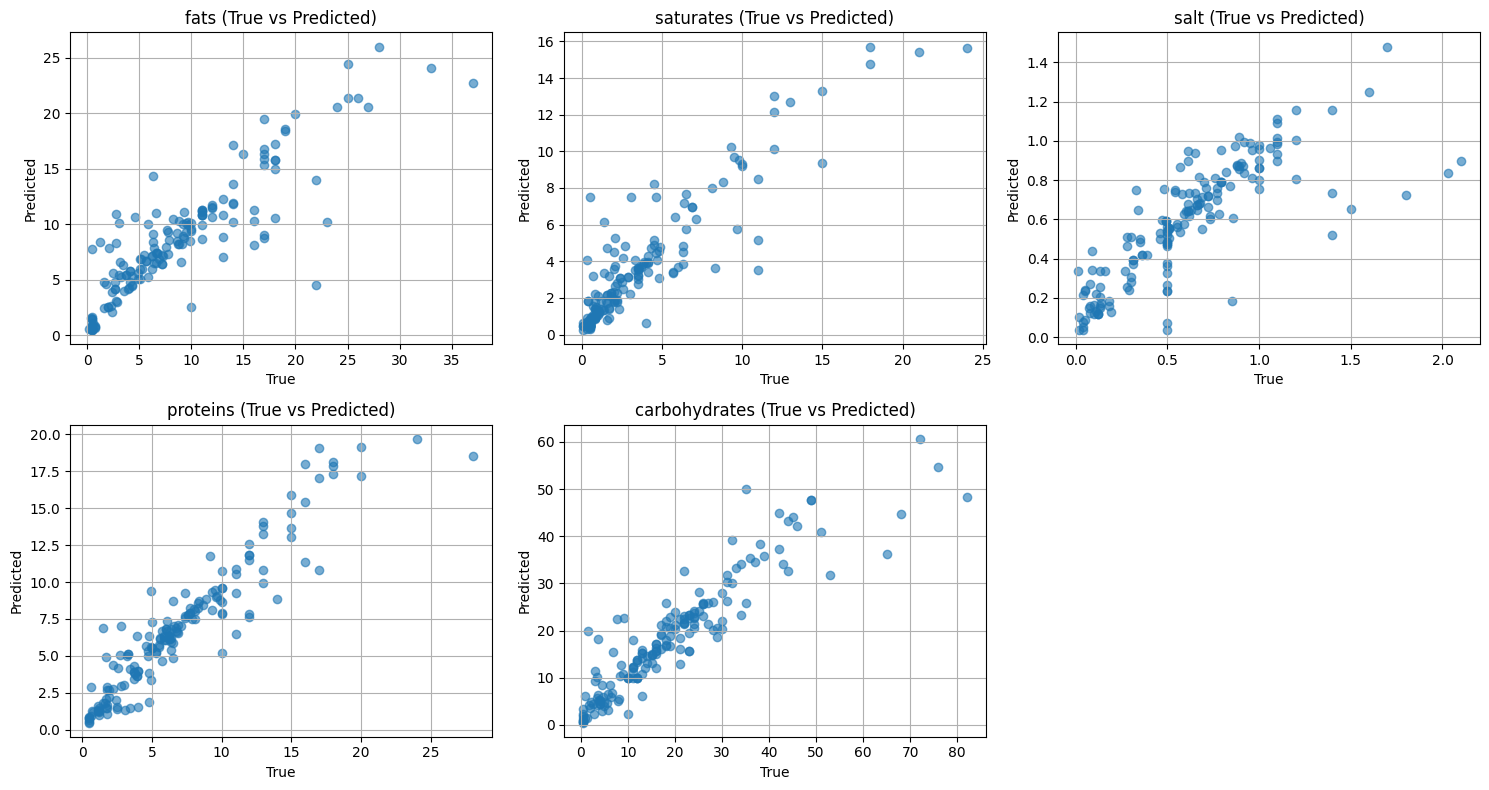

c:\Users\amine\Desktop\Selinium-Scraping-NLP-ML\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


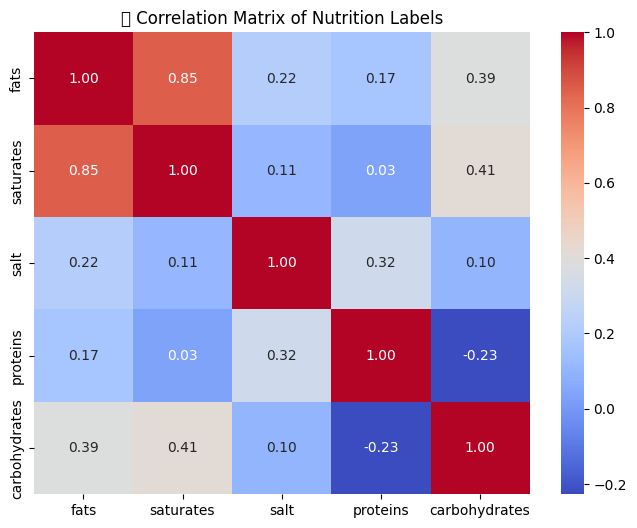

In [6]:
# ⚠️ Ensure df['text'] is preprocessed clean text
vectorizer = TfidfVectorizer(max_features=1000)
df['text'] = df['clean_desc'].fillna('') + ' ' + df['clean_ingredients'].fillna('')
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['text'])

# Drop rows with NaNs in nutrition columns
target_cols = ['fats', 'saturates', 'salt', 'proteins', 'carbohydrates']
df_nutrition = df.dropna(subset=target_cols)

# Align features with cleaned labels
X = vectorizer.transform(df_nutrition['text'])
y = df_nutrition[target_cols]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🧠 Define Models
models = {
    'Ridge': MultiOutputRegressor(Ridge()),
    'LinearRegression': MultiOutputRegressor(LinearRegression()),
    'RandomForest': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    'XGBoost': MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
}

# 📊 Evaluate and Plot
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    r2 = r2_score(y_test, y_pred, multioutput='raw_values')

    results[name] = {
        'mse': mse,
        'r2': r2,
        'preds': y_pred
    }
    
    print(f"\n📌 {name} Performance:")
    for i, col in enumerate(target_cols):
        print(f"→ {col}: MSE={mse[i]:.2f}, R²={r2[i]:.2f}")

# 📈 Plot True vs Predicted
plt.figure(figsize=(15, 8))
for i, col in enumerate(target_cols):
    plt.subplot(2, 3, i+1)
    plt.scatter(y_test[col], results['RandomForest']['preds'][:, i], alpha=0.6)
    plt.title(f"{col} (True vs Predicted)")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.grid(True)
plt.tight_layout()
plt.show()

# 📉 Correlation Matrix (between nutrition facts)
corr_matrix = y.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("📊 Correlation Matrix of Nutrition Labels")
plt.show()

In [14]:
mse_summary = pd.DataFrame()
r2_summary = pd.DataFrame()

for name, result in results.items():
    mse_summary[name] = result['mse']
    r2_summary[name] = result['r2']

mse_summary.index = target_cols
r2_summary.index = target_cols

print("📉 Mean Squared Error (MSE) Comparison:")
display(mse_summary)

print("\n📈 R² Score Comparison:")
display(r2_summary)


📉 Mean Squared Error (MSE) Comparison:


,Ridge,LinearRegression,RandomForest,XGBoost
fats,16.321399,29.286637,14.594622,12.720631
saturates,3.759787,7.897347,3.092845,3.240084
salt,0.060376,0.108996,0.054402,0.060213
proteins,5.963955,10.645340,3.096019,2.984866
carbohydrates,55.887040,62.077796,43.260681,35.931519



📈 R² Score Comparison:


,Ridge,LinearRegression,RandomForest,XGBoost
fats,0.678691,0.423452,0.712685,0.749577
saturates,0.785293,0.549013,0.823380,0.814971
salt,0.624858,0.322763,0.661978,0.625871
proteins,0.766411,0.583056,0.878739,0.883092
carbohydrates,0.766693,0.740849,0.819403,0.850000


C:\Users\amine\AppData\Local\Temp\ipykernel_15540\511337001.py:19: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\amine\AppData\Local\Temp\ipykernel_15540\511337001.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\amine\Desktop\Selinium-Scraping-NLP-ML\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\amine\Desktop\Selinium-Scraping-NLP-ML\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


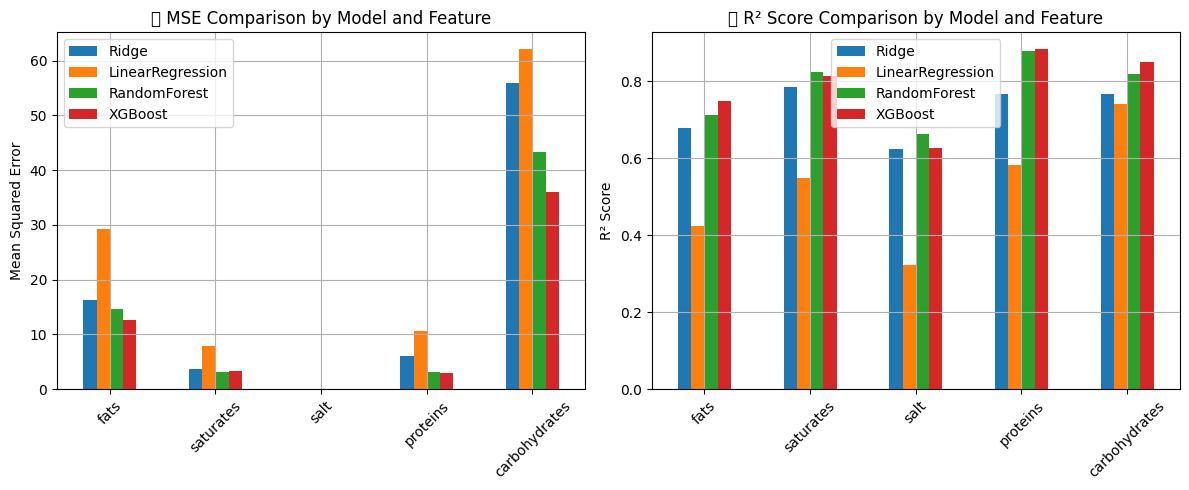

In [15]:
plt.figure(figsize=(12, 5))

# MSE Barplot
plt.subplot(1, 2, 1)
mse_summary.plot(kind='bar', ax=plt.gca())
plt.title("📉 MSE Comparison by Model and Feature")
plt.ylabel("Mean Squared Error")
plt.xticks(rotation=45)
plt.grid(True)

# R² Barplot
plt.subplot(1, 2, 2)
r2_summary.plot(kind='bar', ax=plt.gca())
plt.title("📈 R² Score Comparison by Model and Feature")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()


In [16]:
avg_metrics = pd.DataFrame({
    'Avg MSE': mse_summary.mean(),
    'Avg R²': r2_summary.mean()
})
print("📋 Average Metrics per Model:")
display(avg_metrics.sort_values(by='Avg MSE'))


📋 Average Metrics per Model:


,Avg MSE,Avg R²
XGBoost,10.987463,0.784702
RandomForest,12.819714,0.779237
Ridge,16.398511,0.724389
LinearRegression,22.003223,0.523827
